In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_name = "ff51dd281a8423f1"
image_path = f"../dataset/train/{file_name}.jpg"
coord_path = f"../dataset/train_with_bbox/res_{file_name}.txt"

In [3]:
def read_coordinates_from_file(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file if line.strip()]


def augment_text_regions(image_path, coordinate_path, output_path=None, num_augmentations=1):
    image = cv2.imread(image_path)
    coords = read_coordinates_from_file(coordinate_path)

    for i in range(num_augmentations):
        avg_color = np.mean(image, axis=(0, 1)).astype(int)
        background_color = avg_color + np.random.randint(-20, 21, 3) 
        background_color = np.clip(background_color, 0, 255)
        
        h, w = image.shape[:2]
        background = np.zeros((h, w, 3), dtype=np.uint8)
        for c in range(3):
            background[:, :, c] = np.linspace(background_color[c] - 30, background_color[c] + 30, w)
        
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for coord in coords:
            x1, y1, x2, y2, x3, y3, x4, y4 = map(int, coord.split(','))
            
            pts = np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]], np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(mask, [pts], (255))

        blurred_mask = cv2.GaussianBlur(mask, (21, 21), 0)
        blurred_mask = blurred_mask.reshape(h, w, 1) / 255.0

        text_regions = image * blurred_mask
        background = background * (1 - blurred_mask)
        result = text_regions + background

        if not output_path is None:
            output_file = os.path.join(output_path, f"augmented_{i}.png")
            cv2.imwrite(output_file, result.astype(np.uint8))
        else:
            return result.astype(np.uint8)

In [4]:
def read_coordinates_from_file(file_path):
    with open(file_path, 'r') as file:
        return [line.strip() for line in file if line.strip()]

def augment_text_regions(image_path, coordinate_path, output_path=None, num_augmentations=1, mixup_ratio=0.5):
    image = cv2.imread(image_path)
    coords = read_coordinates_from_file(coordinate_path)

    for i in range(num_augmentations):
        avg_color = np.mean(image, axis=(0, 1)).astype(int)
        background_color = avg_color + np.random.randint(-20, 21, 3)
        background_color = np.clip(background_color, 0, 255)
        
        h, w = image.shape[:2]
        background = np.zeros((h, w, 3), dtype=np.uint8)
        for c in range(3):
            background[:, :, c] = np.linspace(background_color[c] - 30, background_color[c] + 30, w)
        
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for coord in coords:
            x1, y1, x2, y2, x3, y3, x4, y4 = map(int, coord.split(','))
            
            pts = np.array([[x1,y1], [x2,y2], [x3,y3], [x4,y4]], np.int32)
            pts = pts.reshape((-1,1,2))
            cv2.fillPoly(mask, [pts], (255))

        blurred_mask = cv2.GaussianBlur(mask, (21, 21), 0)
        blurred_mask = blurred_mask.reshape(h, w, 1) / 255.0

        text_regions = image * blurred_mask
        background = background * (1 - blurred_mask)
        result = text_regions + background

        # Mixup: 원본 이미지와 최종 결과물을 지정된 비율로 혼합
        mixup_result = cv2.addWeighted(image, mixup_ratio, result.astype(np.uint8), 1 - mixup_ratio, 0)

        if not output_path is None:
            output_file = os.path.join(output_path, f"augmented_mixup_{i}.png")
            cv2.imwrite(output_file, mixup_result)
        else:
            return mixup_result

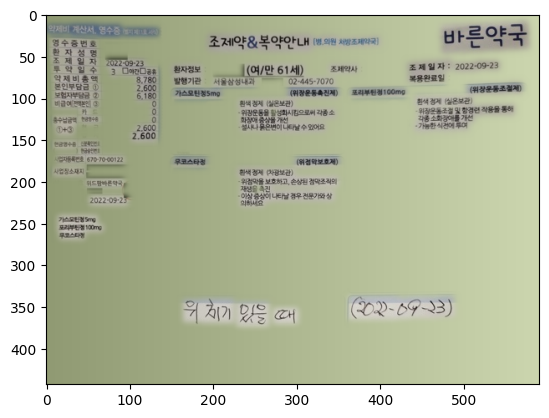

In [10]:
result = augment_text_regions(image_path, coord_path, mixup_ratio=random.uniform(0.0, 0.0))
plt.imshow(result)